In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler


In [2]:
technology = "microarray" # "RNAseq"
#technology = "RNAseq" #microarray

In [3]:

# Assuming your DataFrame is called cts and has gene expression data
# Assuming cts is a pandas DataFrame with gene expression data
if technology == "microarray":
    cts = pd.read_csv("/home/karen/Documents/phd/Data/trainign_dataset_51270_microarray_unadjusted.csv")
elif technology == "RNAseq":
    cts = pd.read_csv("/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/RNAseq_All_abundances_unadjusted.csv")

metadata =   cts[["Experiment", "Sample", "Age"]]


/tmp/ipykernel_14597/3142307427.py:4: DtypeWarning: Columns (51280) have mixed types. Specify dtype option on import or set low_memory=False.
  cts = pd.read_csv("/home/karen/Documents/phd/Data/trainign_dataset_51270_microarray_unadjusted.csv")


In [4]:
metadata

,Experiment,Sample,Age
0,GSE13070,GSM342608,52.50
1,GSE13070,GSM342609,50.60
2,GSE13070,GSM342610,56.08
3,GSE13070,GSM342611,54.84
4,GSE13070,GSM342614,51.14
...,...,...,...
772,GSE9676,GSM244612,65.10
773,GSE9676,GSM244613,68.40
774,GSE9676,GSM244614,65.90
775,GSE9676,GSM244615,67.30


# Function

In [5]:
import matplotlib.pyplot as plt

def generate_colors(n):
        colormap = plt.cm.get_cmap('tab20', n)
        colors = [colormap(i) for i in range(n)]
        return colors
    
def blot_expression(subset_data, experiments, count_experiments, colors=None, title=None, save=False):
    
    if colors is None:
        colors = generate_colors(len(experiments))
    colored = np.sum(list(count_experiments.values()))
    if len(subset_data.columns) != colored:
        raise "the columns and the experiments should be same length"
        return None
    if len(count_experiments) != len(experiments):
        raise "the count_experiments and the experiments should be same length"
        return None
    if title is None:
        title = 'Expression of Gene Expression Across Experiments'
    boxes=[]
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    start_c = 0
    end_c = len(subset_data.columns)
    color_i = 0
    for exp in experiments:
        end_c=start_c + count_experiments[exp]
        # Boxplot for the first 84 columns
        box= ax.boxplot(subset_data.iloc[:, start_c:end_c], positions=list(range(start_c+1,end_c+1)), showfliers=False, patch_artist=True,
                          boxprops=dict(facecolor=colors[color_i], color=colors[color_i])
                          )
        start_c = end_c
        boxes.append(box)
        color_i=color_i+1
                          
    
    # Set labels and titles
    ax.set_title(title)
    ax.set_ylabel('Expression')
    
    # Adjust legend
    legends_list = [b["boxes"][0] for b in boxes]
    ax.legend(legends_list, experiments)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()


In [6]:
def two_step_normalization( data: pd.DataFrame):
        """
        Two step normalization from Ivan Izonin et al, 2022.  Two-Step Data Normalization Approach for Improving 
        Classification Accuracy in the Medical Diagnosis Domain.
        1. Max Abs Scaler
        2. L2 normalization
        3. Add norm feature
        4. L2 normalization
        5. Return the normalized dataset
        """
        dataset = data.values
        # Initialize the Max Abs Scaler (step 1)
        scaler = MaxAbsScaler()

        # Fit and transform the data Equation (1)
        dataset = scaler.fit_transform(dataset)
        # Calculate the norm of each vector in the dataset using Equation (2)
        norms = np.sqrt(np.sum(dataset ** 2, axis=1))
        # Apply Equation (3) to calculate the norm of each vector in the dataset
        dataset = np.divide(dataset, norms[:, np.newaxis])
        # add norm feature
        dataset = np.column_stack((dataset, norms))

        
        # let's repeat the scaler
        scaler_2 = StandardScaler()
        dataset = scaler_2.fit_transform(dataset)

        # dataset = np.delete(dataset, -1, axis=1)
        # transform back to dataframe and return
        columns = list(data.columns)
        columns.append('norm')
        return pd.DataFrame(dataset, index=data.index, columns=columns)

In [7]:
cts

,Sample,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,...,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Sex,Age,Status
0,GSM342608,870.599976,500.399994,165.000000,900.900024,67.400002,346.600006,255.300003,58.000000,70.800003,...,341.000000,2384.300049,101.699997,59.500000,159.399994,233.000000,GSE13070,Male,52.50,IRd
1,GSM342609,1635.300049,390.899994,252.199997,795.000000,108.300003,623.000000,260.500000,76.400002,4.200000,...,292.399994,3852.000000,70.699997,32.700001,155.899994,383.200012,GSE13070,Male,50.60,IRd
2,GSM342610,1006.799988,383.200012,198.199997,924.000000,129.399994,649.599976,192.800003,40.700001,16.200001,...,263.799988,2043.599976,165.000000,94.099998,220.100006,399.100006,GSE13070,Male,56.08,IRd � TZD
3,GSM342611,1215.800049,496.200012,160.600006,500.899994,18.799999,345.299988,257.600006,23.400000,41.500000,...,238.100006,2176.800049,93.599998,21.799999,183.899994,483.899994,GSE13070,Male,54.84,IRd � TZD
4,GSM342614,823.599976,561.500000,305.500000,1214.099976,81.300003,494.399994,208.199997,63.799999,79.199997,...,223.899994,2341.699951,142.600006,79.699997,341.299988,397.399994,GSE13070,Male,51.14,IRd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,GSM244612,1316.250000,1582.450000,11268.600000,7065.080000,6376.640000,1996.200000,10128.300000,7015.010000,235.884000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.10,NaN
773,GSM244613,966.504000,889.863000,9753.840000,4753.410000,6072.460000,1229.210000,6264.000000,5658.760000,335.332000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,68.40,NaN
774,GSM244614,1382.900000,1278.390000,11248.800000,7119.220000,6891.120000,1431.700000,8131.630000,6416.350000,432.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.90,NaN
775,GSM244615,1498.540000,1276.440000,10965.900000,6940.470000,7879.880000,1917.330000,7469.210000,6153.410000,440.064000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,67.30,NaN


In [8]:
sample_order = cts["Sample"].tolist()  # Get the order of samples in cts
experiment_order = cts["Experiment"].tolist() 
age_order = cts["Age"].tolist()


In [9]:
df =pd.DataFrame(experiment_order)
count_experiments = dict(df[0].value_counts())
count_experiments
experiments = list(count_experiments)
experiments

['GSE13070',
 'GSE47969',
 'GSE48278',
 'GSE9103',
 'GSE59880',
 'GSE9676',
 'GSE161643',
 'GSE8157',
 'GSE1428',
 'GSE38718',
 'GSE6348',
 'GSE40551',
 'GSE87105',
 'GSE674_2']

In [10]:
def map_to_category(age):
    if age <= 35:
        return "Young"
    elif age > 65:
        return "Old"
    else:
        return "MiddleAge"

# Map values in age_order to categories
age_order = [map_to_category(age) for age in age_order]

In [11]:
cts

,Sample,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,...,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Sex,Age,Status
0,GSM342608,870.599976,500.399994,165.000000,900.900024,67.400002,346.600006,255.300003,58.000000,70.800003,...,341.000000,2384.300049,101.699997,59.500000,159.399994,233.000000,GSE13070,Male,52.50,IRd
1,GSM342609,1635.300049,390.899994,252.199997,795.000000,108.300003,623.000000,260.500000,76.400002,4.200000,...,292.399994,3852.000000,70.699997,32.700001,155.899994,383.200012,GSE13070,Male,50.60,IRd
2,GSM342610,1006.799988,383.200012,198.199997,924.000000,129.399994,649.599976,192.800003,40.700001,16.200001,...,263.799988,2043.599976,165.000000,94.099998,220.100006,399.100006,GSE13070,Male,56.08,IRd � TZD
3,GSM342611,1215.800049,496.200012,160.600006,500.899994,18.799999,345.299988,257.600006,23.400000,41.500000,...,238.100006,2176.800049,93.599998,21.799999,183.899994,483.899994,GSE13070,Male,54.84,IRd � TZD
4,GSM342614,823.599976,561.500000,305.500000,1214.099976,81.300003,494.399994,208.199997,63.799999,79.199997,...,223.899994,2341.699951,142.600006,79.699997,341.299988,397.399994,GSE13070,Male,51.14,IRd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,GSM244612,1316.250000,1582.450000,11268.600000,7065.080000,6376.640000,1996.200000,10128.300000,7015.010000,235.884000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.10,NaN
773,GSM244613,966.504000,889.863000,9753.840000,4753.410000,6072.460000,1229.210000,6264.000000,5658.760000,335.332000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,68.40,NaN
774,GSM244614,1382.900000,1278.390000,11248.800000,7119.220000,6891.120000,1431.700000,8131.630000,6416.350000,432.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.90,NaN
775,GSM244615,1498.540000,1276.440000,10965.900000,6940.470000,7879.880000,1917.330000,7469.210000,6153.410000,440.064000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,67.30,NaN


In [12]:
cts_processed = cts.copy()
#
if technology == "microarray":
    cts_processed.drop(['Age', 'Sex', 'Status', 'Experiment'], axis=1, inplace=True)
elif technology == "RNAseq":
    cts_processed.drop(['Age', 'Sample.1', 'Experiment'], axis=1, inplace=True)
cts_processed.set_index("Sample",  inplace=True)

In [13]:
#!pip install combat

In [14]:
from combat.pycombat import pycombat
data = cts.copy()

# Extract batch information into a separate variable
# Replace 'batch_column_name' with the name of the column containing batch information
batch_info = data['Experiment']
age_list = data["Age"]
# Remove the batch column from the data
if technology == "microarray":
    data.drop(['Age', 'Sex', 'Status', 'Experiment'], axis=1, inplace=True)

elif technology == "RNAseq":
    data.drop(['Age', 'Sample.1', 'Experiment'], axis=1, inplace=True)


data.set_index("Sample", inplace=True)


In [15]:
data= data.T

In [16]:
data

Sample,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,870.599976,1635.300049,1006.799988,1215.800049,823.599976,1174.000000,871.799988,1531.000000,837.700012,1026.400024,...,893.719,1307.66,1167.92,962.987,1098.29,1316.25,966.504,1382.90,1498.54,1127.14
M87338,500.399994,390.899994,383.200012,496.200012,561.500000,544.400024,511.100006,409.700012,352.100006,604.299988,...,1195.870,1416.94,1721.65,1196.380,1544.92,1582.45,889.863,1278.39,1276.44,1247.63
X51757,165.000000,252.199997,198.199997,160.600006,305.500000,239.899994,273.600006,121.099998,140.500000,211.600006,...,10278.600,10395.10,10960.90,11494.600,12586.50,11268.60,9753.840,11248.80,10965.90,11196.30
X69699,900.900024,795.000000,924.000000,500.899994,1214.099976,609.299988,531.000000,652.599976,821.000000,570.700012,...,5435.160,6138.75,8321.32,8694.850,7740.13,7065.08,4753.410,7119.22,6940.47,4809.99
L36861,67.400002,108.300003,129.399994,18.799999,81.300003,9.600000,83.300003,17.200001,12.900000,81.500000,...,6007.200,7298.46,6727.35,6784.570,6309.06,6376.64,6072.460,6891.12,7879.88,6443.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,2384.300049,3852.000000,2043.599976,2176.800049,2341.699951,3027.199951,2351.600098,2876.600098,2640.500000,2613.000000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
C18318,101.699997,70.699997,165.000000,93.599998,142.600006,111.800003,12.000000,146.100006,101.199997,64.500000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI219073,59.500000,32.700001,94.099998,21.799999,79.699997,46.400002,34.299999,58.799999,15.000000,109.800003,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI205180,159.399994,155.899994,220.100006,183.899994,341.299988,371.600006,311.200012,347.899994,517.200012,303.799988,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00


In [17]:
colors=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

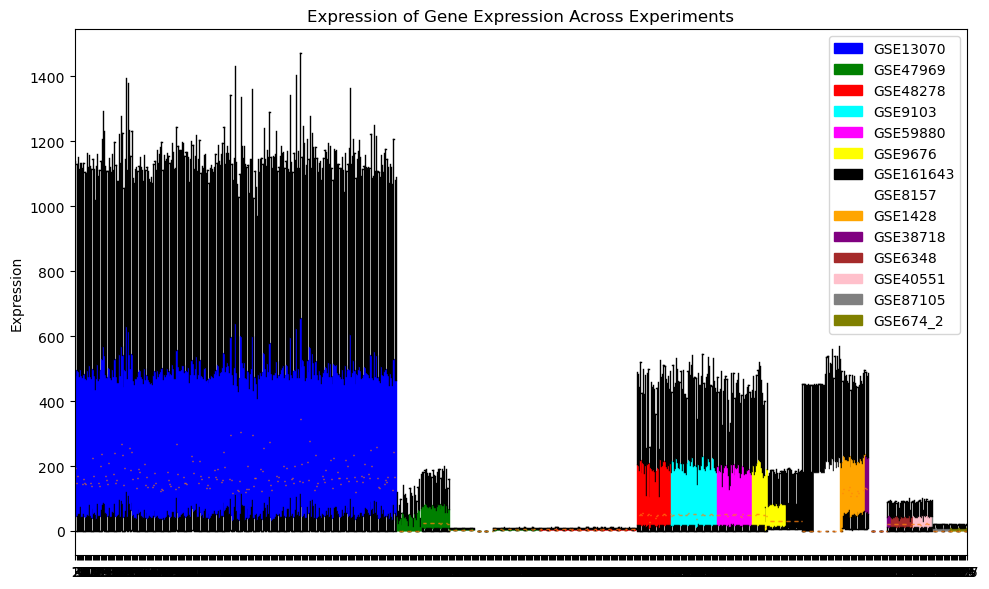

In [18]:

blot_expression(data, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_unalteraded.png")



In [19]:

data = two_step_normalization(data)
data.drop(columns=["norm"], inplace=True)
data= data.T

In [20]:
data.columns

Index(['U48705', 'M87338', 'X51757', 'X69699', 'L36861', 'L13852', 'X55005',
       'X79510', 'M21121', 'J02843',
       ...
       'AW050627', 'AI654857', 'W22117', 'AI028241', 'AI571298', 'AA149545',
       'C18318', 'AI219073', 'AI205180', 'AI363375'],
      dtype='object', length=51276)

In [21]:
data.dropna(inplace=True)
data

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AW050627,AI654857,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375
GSM342608,-0.035884,-0.126985,-0.238269,0.031090,-0.268879,-0.147148,-0.241418,-0.305231,-0.273948,-0.204793,...,-0.111738,0.040539,-0.325717,-0.152833,-0.157644,0.629668,-0.243602,-0.297567,-0.261679,-0.190761
GSM342609,0.276206,-0.171927,-0.181161,0.005139,-0.226090,0.029520,-0.243250,-0.302272,-0.352816,-0.183999,...,-0.256913,-0.035044,-0.253564,-0.057041,-0.182657,1.367152,-0.281273,-0.329739,-0.269721,-0.082058
GSM342610,0.023628,-0.175506,-0.216904,0.053492,-0.199350,0.036362,-0.268545,-0.321223,-0.332613,-0.292615,...,-0.239375,-0.150669,-0.321300,-0.037639,-0.198607,0.525385,-0.179567,-0.273355,-0.231016,-0.075179
GSM342611,0.113258,-0.123541,-0.247295,-0.130543,-0.337126,-0.144576,-0.246666,-0.343073,-0.315187,-0.244394,...,-0.343533,-0.084346,-0.206546,-0.071130,-0.217099,0.619177,-0.258841,-0.341534,-0.256177,-0.010739
GSM342614,-0.061906,-0.105034,-0.148296,0.129787,-0.242213,-0.071779,-0.248218,-0.285169,-0.253147,-0.215518,...,0.068488,0.031668,-0.312586,-0.066680,-0.213411,0.534292,-0.197343,-0.267778,-0.165958,-0.089375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,0.922424,1.406879,15.743574,6.381130,15.453468,2.391348,8.825820,10.074036,0.406339,4.446792,...,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232
GSM244613,0.747734,0.856204,15.412504,4.830901,16.654664,1.633319,6.142614,9.182803,0.716021,3.530808,...,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050
GSM244614,0.996668,1.142613,16.135196,6.600110,17.154918,1.727051,7.251751,9.449469,0.850909,3.999164,...,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039
GSM244615,0.996771,1.044241,14.513383,5.930047,18.120023,2.161437,6.133532,8.355058,0.791629,4.318255,...,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660


In [22]:
data[data.isna().any(axis=1)]

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AW050627,AI654857,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375


In [23]:
filtered_data = data[(data == 0).all(axis=1)]
data = data.drop(filtered_data.index)
data

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AW050627,AI654857,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375
GSM342608,-0.035884,-0.126985,-0.238269,0.031090,-0.268879,-0.147148,-0.241418,-0.305231,-0.273948,-0.204793,...,-0.111738,0.040539,-0.325717,-0.152833,-0.157644,0.629668,-0.243602,-0.297567,-0.261679,-0.190761
GSM342609,0.276206,-0.171927,-0.181161,0.005139,-0.226090,0.029520,-0.243250,-0.302272,-0.352816,-0.183999,...,-0.256913,-0.035044,-0.253564,-0.057041,-0.182657,1.367152,-0.281273,-0.329739,-0.269721,-0.082058
GSM342610,0.023628,-0.175506,-0.216904,0.053492,-0.199350,0.036362,-0.268545,-0.321223,-0.332613,-0.292615,...,-0.239375,-0.150669,-0.321300,-0.037639,-0.198607,0.525385,-0.179567,-0.273355,-0.231016,-0.075179
GSM342611,0.113258,-0.123541,-0.247295,-0.130543,-0.337126,-0.144576,-0.246666,-0.343073,-0.315187,-0.244394,...,-0.343533,-0.084346,-0.206546,-0.071130,-0.217099,0.619177,-0.258841,-0.341534,-0.256177,-0.010739
GSM342614,-0.061906,-0.105034,-0.148296,0.129787,-0.242213,-0.071779,-0.248218,-0.285169,-0.253147,-0.215518,...,0.068488,0.031668,-0.312586,-0.066680,-0.213411,0.534292,-0.197343,-0.267778,-0.165958,-0.089375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,0.922424,1.406879,15.743574,6.381130,15.453468,2.391348,8.825820,10.074036,0.406339,4.446792,...,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232
GSM244613,0.747734,0.856204,15.412504,4.830901,16.654664,1.633319,6.142614,9.182803,0.716021,3.530808,...,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050
GSM244614,0.996668,1.142613,16.135196,6.600110,17.154918,1.727051,7.251751,9.449469,0.850909,3.999164,...,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039
GSM244615,0.996771,1.044241,14.513383,5.930047,18.120023,2.161437,6.133532,8.355058,0.791629,4.318255,...,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660


In [24]:
data.fillna(0, inplace=True)

In [25]:
#blot_expression(data, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_combat_double_normalized.png")

In [26]:
age_list

0      52.50
1      50.60
2      56.08
3      54.84
4      51.14
       ...  
772    65.10
773    68.40
774    65.90
775    67.30
776    67.90
Name: Age, Length: 777, dtype: float64

In [27]:
batch_info

0      GSE13070
1      GSE13070
2      GSE13070
3      GSE13070
4      GSE13070
         ...   
772     GSE9676
773     GSE9676
774     GSE9676
775     GSE9676
776     GSE9676
Name: Experiment, Length: 777, dtype: object

In [28]:
data

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AW050627,AI654857,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375
GSM342608,-0.035884,-0.126985,-0.238269,0.031090,-0.268879,-0.147148,-0.241418,-0.305231,-0.273948,-0.204793,...,-0.111738,0.040539,-0.325717,-0.152833,-0.157644,0.629668,-0.243602,-0.297567,-0.261679,-0.190761
GSM342609,0.276206,-0.171927,-0.181161,0.005139,-0.226090,0.029520,-0.243250,-0.302272,-0.352816,-0.183999,...,-0.256913,-0.035044,-0.253564,-0.057041,-0.182657,1.367152,-0.281273,-0.329739,-0.269721,-0.082058
GSM342610,0.023628,-0.175506,-0.216904,0.053492,-0.199350,0.036362,-0.268545,-0.321223,-0.332613,-0.292615,...,-0.239375,-0.150669,-0.321300,-0.037639,-0.198607,0.525385,-0.179567,-0.273355,-0.231016,-0.075179
GSM342611,0.113258,-0.123541,-0.247295,-0.130543,-0.337126,-0.144576,-0.246666,-0.343073,-0.315187,-0.244394,...,-0.343533,-0.084346,-0.206546,-0.071130,-0.217099,0.619177,-0.258841,-0.341534,-0.256177,-0.010739
GSM342614,-0.061906,-0.105034,-0.148296,0.129787,-0.242213,-0.071779,-0.248218,-0.285169,-0.253147,-0.215518,...,0.068488,0.031668,-0.312586,-0.066680,-0.213411,0.534292,-0.197343,-0.267778,-0.165958,-0.089375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,0.922424,1.406879,15.743574,6.381130,15.453468,2.391348,8.825820,10.074036,0.406339,4.446792,...,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232,-0.104232
GSM244613,0.747734,0.856204,15.412504,4.830901,16.654664,1.633319,6.142614,9.182803,0.716021,3.530808,...,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050,-0.105050
GSM244614,0.996668,1.142613,16.135196,6.600110,17.154918,1.727051,7.251751,9.449469,0.850909,3.999164,...,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039,-0.111039
GSM244615,0.996771,1.044241,14.513383,5.930047,18.120023,2.161437,6.133532,8.355058,0.791629,4.318255,...,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660,-0.111660


In [29]:
batch_info

0      GSE13070
1      GSE13070
2      GSE13070
3      GSE13070
4      GSE13070
         ...   
772     GSE9676
773     GSE9676
774     GSE9676
775     GSE9676
776     GSE9676
Name: Experiment, Length: 777, dtype: object

In [31]:
data_corrected = pycombat(data=data.T,batch=batch_info, mod=[], precision=0.1)

Found 14 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [32]:
data_corrected

,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,-0.209866,0.322070,-0.108433,0.044337,-0.254220,0.024337,-0.191959,0.289266,-0.209936,-0.089879,...,-0.156681,0.170183,-0.001370,-0.351287,0.037478,0.493360,-0.070087,0.732825,0.733159,0.060684
M87338,-0.308736,-0.354750,-0.358415,-0.305209,-0.286261,-0.279740,-0.294699,-0.354362,-0.370703,-0.253743,...,-0.244500,-0.262813,-0.211020,-0.273082,-0.218447,-0.220872,-0.302801,-0.260189,-0.274825,-0.265668
X51757,0.638611,0.668211,0.649685,0.633933,0.685245,0.663140,0.678883,0.612084,0.630579,0.654278,...,1.141249,1.018565,1.066989,1.116054,1.180843,1.100343,1.089772,1.112847,1.061065,1.105542
X69699,0.466297,0.449587,0.480723,0.362216,0.529852,0.395590,0.373150,0.407231,0.453994,0.382578,...,0.714245,0.664884,0.803132,0.849092,0.805397,0.750099,0.653277,0.763775,0.721926,0.625377
L36861,0.552979,0.575077,0.588887,0.517733,0.566750,0.511227,0.565976,0.506981,0.519782,0.559807,...,1.079864,1.039415,1.025009,1.058136,1.032224,1.018029,1.059082,1.076179,1.109163,1.032604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,0.195086,0.823389,0.106241,0.186147,0.113830,0.526187,0.198684,0.513466,0.331047,0.326724,...,0.338618,0.338744,0.338395,0.340816,0.337677,0.338922,0.338657,0.336715,0.336514,0.338437
C18318,-0.120960,-0.267757,0.128575,-0.180343,0.059304,-0.103452,-0.437699,0.004279,-0.120344,-0.279077,...,-0.179170,-0.178980,-0.179504,-0.175874,-0.180580,-0.178714,-0.179111,-0.182022,-0.182324,-0.179441
AI219073,-0.172133,-0.214351,-0.140361,-0.229830,-0.133043,-0.203808,-0.188581,-0.210796,-0.222596,-0.124929,...,-0.174924,-0.174711,-0.175298,-0.171236,-0.176501,-0.174414,-0.174858,-0.178115,-0.178453,-0.175227
AI205180,-0.142514,-0.149968,-0.114096,-0.137415,-0.053799,-0.038034,-0.062681,-0.057800,0.036494,-0.072184,...,-0.054440,-0.054283,-0.054715,-0.051725,-0.055601,-0.054064,-0.054392,-0.056789,-0.057037,-0.054663


In [33]:
data_corrected[data_corrected.isna().any(axis=1)]


,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616


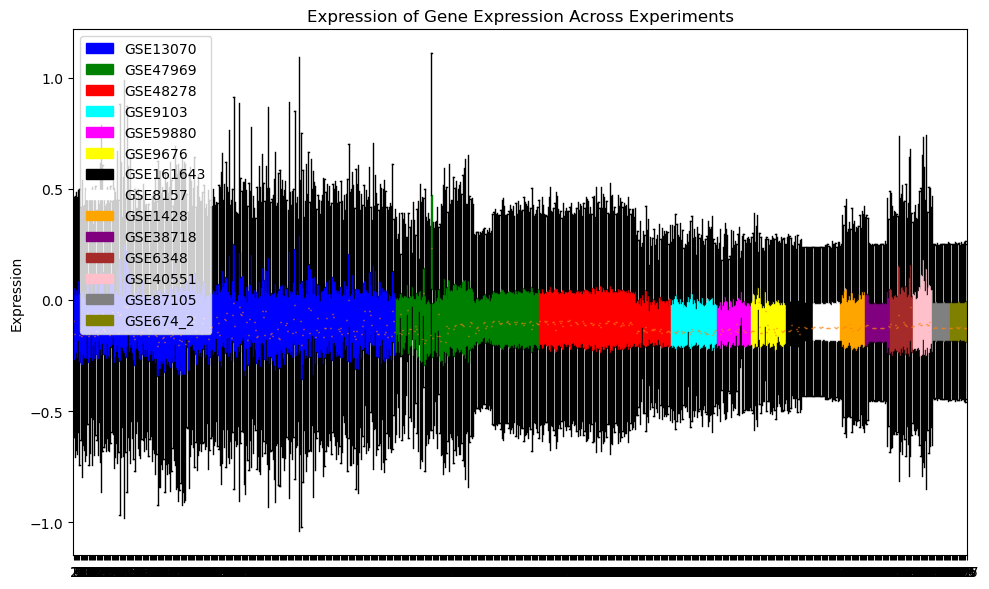

In [34]:
blot_expression(data_corrected, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_adjustedCombat_double_norm.png")

In [35]:
#blot_expression(data_corrected, experiments, count_experiments, colors=["blue", "green", "orange", "pink","red","purple"])

In [36]:
data_corrected = data_corrected.T

# Testing batch correction

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Set significance threshold (alpha level)

def plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05):
    # Plot histograms of p-values before and after batch correction
    plt.figure(figsize=(10, 5))
    plt.hist(p_values_before, bins=50, color='blue', alpha=0.5, label='Before Correction')
    plt.hist(p_values_after, bins=50, color='green', alpha=0.5, label='After Correction')
    plt.axvline(alpha, color='red', linestyle='--', label='Significance Threshold')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of p-values before and after batch correction')
    plt.legend()
    plt.show()
    
    # Perform Kolmogorov-Smirnov test to compare distributions of p-values
    ks_stat, ks_p_value = ks_2samp(p_values_before, p_values_after)
    print("Kolmogorov-Smirnov test p-value:", ks_p_value)
    
    # Check if more p-values fall below the significance threshold after batch correction
    num_sig_before = np.sum(p_values_before < alpha)
    num_sig_after = np.sum(p_values_after < alpha)
    
    print("Number of significant p-values before correction:", num_sig_before)
    print("Number of significant p-values after correction:", num_sig_after)

def see_distribution(p_values_before, p_values_after):

    # Plot histograms of p-values before and after batch correction
    plt.figure(figsize=(10, 5))
    sns.histplot(p_values_before, bins=50, color='blue', kde=True, label='Before Correction')
    sns.histplot(p_values_after, bins=50, color='green', kde=True, label='After Correction')
    plt.axvline(alpha, color='red', linestyle='--', label='Significance Threshold')
    plt.xlabel('p-value')
    plt.ylabel('Density')
    plt.title('Distribution of p-values before and after batch correction')
    plt.legend()
    plt.show()


In [65]:
def get_ks_values_before_after(data, data_corrected, experiment_1, experiment_2):
    data_before = data.copy()
    data_before = data_before.T
    data_before.reset_index(drop=True, inplace=True)
    
    #group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    exp1= list(cts['Experiment'] == experiment_1)
    group_a_samples_before = data_before[exp1]
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    ks_stat_before, ks_p_value_before = ks_2samp(group_a_samples_before, group_b_samples_before)

    data_corrected.reset_index(drop=True, inplace=True)

    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    _, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    ks_stat_after, ks_p_value_after = ks_2samp(group_a_samples_corrected, group_b_samples_corrected)

    return ks_p_value_before, ks_p_value_after




In [68]:
def get_p_values_before_after(data, data_corrected, experiment_1, experiment_2):
    data_before = data.copy()
    data_before = data_before.T
    data_before.reset_index(drop=True, inplace=True)
    
    #group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    exp1= list(cts['Experiment'] == experiment_1)
    group_a_samples_before = data_before[exp1]
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)

    data_corrected.reset_index(drop=True, inplace=True)

    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    _, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)

    return p_values_before, p_values_after

In [40]:
experiment_list = experiments
experiments

['GSE13070',
 'GSE47969',
 'GSE48278',
 'GSE9103',
 'GSE59880',
 'GSE9676',
 'GSE161643',
 'GSE8157',
 'GSE1428',
 'GSE38718',
 'GSE6348',
 'GSE40551',
 'GSE87105',
 'GSE674_2']

In [41]:
experiment_1 = experiments[0]
experiment_2 = experiments[1]

In [72]:
# Perform differential expression analysis after batch correction

data=data.T
data

,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,-0.035884,0.276206,0.023628,0.113258,-0.061906,0.101524,-0.025378,0.256959,-0.035925,0.034513,...,0.720886,0.822227,0.769039,0.660551,0.781083,0.922424,0.747734,0.996668,0.996771,0.788278
M87338,-0.126985,-0.171927,-0.175506,-0.123541,-0.105034,-0.098665,-0.113275,-0.171548,-0.187508,-0.073274,...,1.248062,1.124977,1.473092,1.055956,1.423178,1.406879,0.856204,1.142613,1.044241,1.105785
X51757,-0.238269,-0.181161,-0.216904,-0.247295,-0.148296,-0.190944,-0.160571,-0.289448,-0.253765,-0.208041,...,17.024745,13.182285,14.698941,16.235626,18.264824,15.743574,15.412504,16.135196,14.513383,15.906420
X69699,0.031090,0.005139,0.053492,-0.130543,0.129787,-0.078715,-0.113563,-0.060638,0.011983,-0.098921,...,5.807063,5.016733,7.230263,7.966143,7.266535,6.381130,4.830901,6.600110,5.930047,4.384177
L36861,-0.268879,-0.226090,-0.199350,-0.337126,-0.242213,-0.349724,-0.243713,-0.357945,-0.333159,-0.255658,...,17.262743,16.079221,15.657714,16.626981,15.868794,15.453468,16.654664,17.154918,18.120023,15.879922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,0.629668,1.367152,0.525385,0.619177,0.534292,1.018305,0.633892,1.003373,0.789256,0.784181,...,-0.105170,-0.104779,-0.105858,-0.098388,-0.108071,-0.104232,-0.105050,-0.111039,-0.111660,-0.105728
C18318,-0.243602,-0.281273,-0.179567,-0.258841,-0.197343,-0.239110,-0.324883,-0.211464,-0.243444,-0.284178,...,-0.105170,-0.104779,-0.105858,-0.098388,-0.108071,-0.104232,-0.105050,-0.111039,-0.111660,-0.105728
AI219073,-0.297567,-0.329739,-0.273355,-0.341534,-0.267778,-0.321705,-0.310101,-0.327030,-0.336022,-0.261595,...,-0.105170,-0.104779,-0.105858,-0.098388,-0.108071,-0.104232,-0.105050,-0.111039,-0.111660,-0.105728
AI205180,-0.261679,-0.269721,-0.231016,-0.256177,-0.165958,-0.148947,-0.175541,-0.170274,-0.068534,-0.185794,...,-0.105170,-0.104779,-0.105858,-0.098388,-0.108071,-0.104232,-0.105050,-0.111039,-0.111660,-0.105728


In [73]:
p_values_before, p_values_after = get_p_values_before_after(data, data_corrected, experiment_1, experiment_2)

In [74]:
p_values_before

array([3.34857035e-164, 3.83285684e-252, 4.03360401e-098, ...,
       9.35962751e-016, 5.79334669e-045, 6.96711733e-002])

In [75]:
p_values_after

array([0.8553088 , 0.08057472, 0.45247286, ..., 0.86113094, 0.77097296,
       0.9887119 ])

In [76]:
#plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


In [77]:
p_values_after

array([0.8553088 , 0.08057472, 0.45247286, ..., 0.86113094, 0.77097296,
       0.9887119 ])

## Getting all the experiments p_values


In [78]:
import itertools


In [79]:
expriments_pvalue_before=[]
expriments_pvalue_after=[]
combination_list = []
ks_stats =  []

for experiment_1, experiment_2 in itertools.combinations(experiment_list, 2):
    combination_list.append(f"{experiment_1}-{experiment_2}")
    p_values_before, p_values_after = get_p_values_before_after(data, data_corrected, experiment_1, experiment_2)
    expriments_pvalue_before.append(p_values_before)
    expriments_pvalue_after.append(p_values_after)
    ks_stat, ks_p_value = ks_2samp(p_values_before, p_values_after)
    ks_stats.append({"combination":f"{experiment_1}-{experiment_2}","ks_stat":ks_stat, "ks_pvalue": ks_p_value})



In [80]:
# Convert lists to arrays
expriments_pvalue_before_array = np.array(expriments_pvalue_before)
expriments_pvalue_after_array = np.array(expriments_pvalue_after)

# Calculate average and standard deviation for p-values before and after
avg_p_values_before = np.mean(expriments_pvalue_before_array, axis=1)
std_p_values_before = np.std(expriments_pvalue_before_array, axis=1)
avg_p_values_after = np.mean(expriments_pvalue_after_array, axis=1)
std_p_values_after = np.std(expriments_pvalue_after_array, axis=1)

# Create DataFrame for KS test results
ks_stats_df = pd.DataFrame(ks_stats)


# Add columns for average and standard deviation of p-values before and after
ks_stats_df["avg_p_values_before"] = avg_p_values_before
ks_stats_df["std_p_values_before"] = std_p_values_before
ks_stats_df["avg_p_values_after"] = avg_p_values_after
ks_stats_df["std_p_values_after"] = std_p_values_after


In [81]:
ks_stats_df.drop(columns=["ks_stat", "ks_pvalue"])

,combination,avg_p_values_before,std_p_values_before,avg_p_values_after,std_p_values_after
0,GSE13070-GSE47969,0.036024,0.140483,0.788098,0.219504
1,GSE13070-GSE48278,0.018830,0.103450,0.900193,0.185662
2,GSE13070-GSE9103,0.067219,0.186586,0.852416,0.228008
3,GSE13070-GSE59880,0.080284,0.200962,0.784356,0.225184
4,GSE13070-GSE9676,0.030442,0.129775,0.870424,0.206943
...,...,...,...,...,...
86,GSE6348-GSE87105,0.027974,0.124455,0.114902,0.238553
87,GSE6348-GSE674_2,0.023627,0.115717,0.174012,0.243310
88,GSE40551-GSE87105,0.066735,0.149355,0.291858,0.333285
89,GSE40551-GSE674_2,0.026189,0.119196,0.358236,0.326898


In [82]:
ks_stats_df.to_csv(f"ttstat_difference_{technology}_experiments_before_after_combat_double_norm.csv")

Heatmap the similarity of the experiments

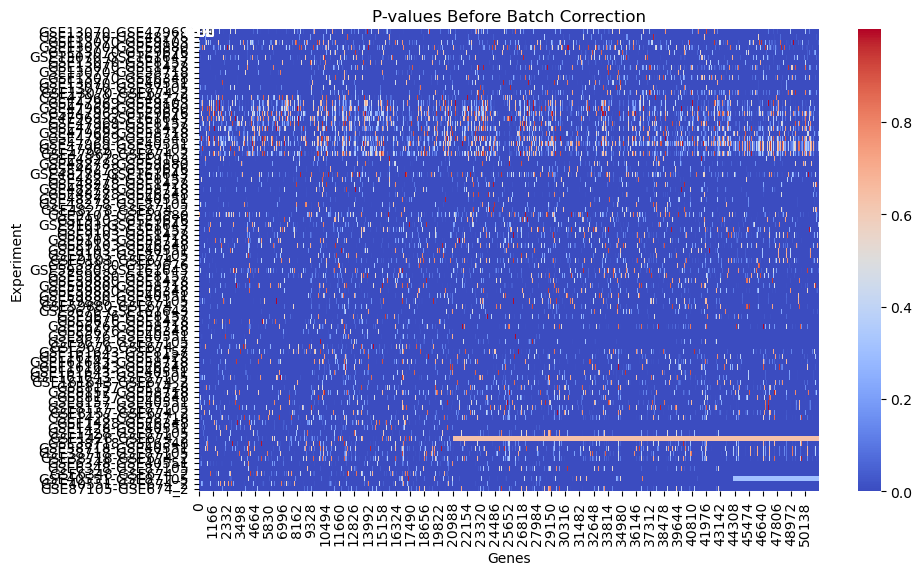

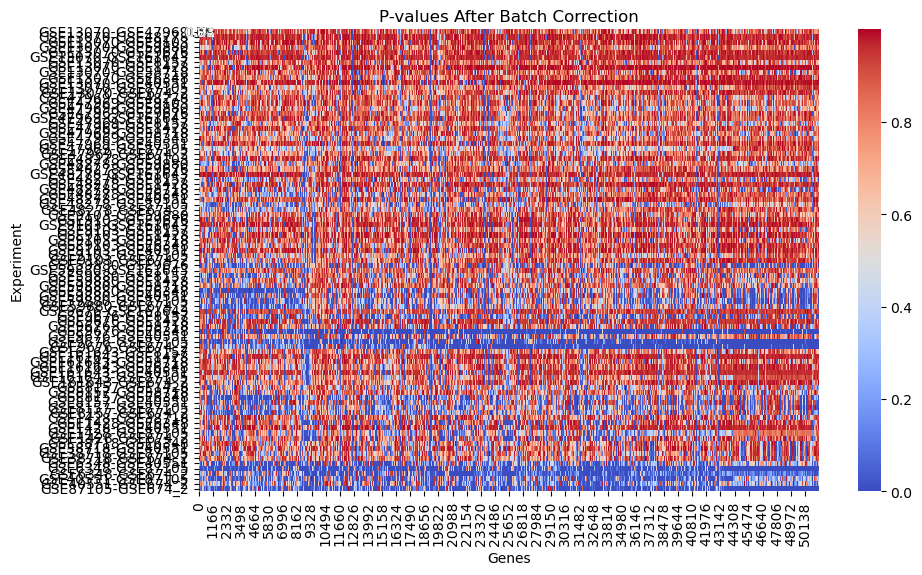

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists of p-values to a 2D NumPy array
p_values_before_array = np.array(expriments_pvalue_before)
p_values_after_array = np.array(expriments_pvalue_after)

# Create a heatmap for p-values before batch correction
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_before_array, cmap='coolwarm', annot=True, fmt=".2f", yticklabels=combination_list)
plt.title('P-values Before Batch Correction')
plt.xlabel('Genes')
plt.ylabel('Experiment')
plt.savefig(f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_heatmap_before_double_norm.png")
plt.show()

# Create a heatmap for p-values after batch correction
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_after_array, cmap='coolwarm', annot=True, fmt=".2f", yticklabels=combination_list)
plt.title('P-values After Batch Correction')
plt.xlabel('Genes')
plt.ylabel('Experiment')
plt.savefig(f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_heatmap_after_double_norm.png")
plt.show()

### Looking with the DE genes only

DE only in one experiment

In [84]:
import pandas as pd
experiment="GSE157585"

def get_columns_to_keep_one(experiment):
    # Path to the CSV file
    file_path = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment}_DDS.csv'
    
    # Read the CSV file
    de_genes = pd.read_csv(file_path, index_col=0)
    
    # Filter rows based on condition
    filtered_data = de_genes[(abs(de_genes['log2FoldChange']) > 1) & (de_genes['padj'] < 0.1)]
    
    # Extract column names from filtered data
    columns_to_keep = filtered_data["row"].str.strip().tolist()
    return columns_to_keep

# Assuming p_values_before is another DataFrame you want to filter columns from
# Replace p_values_before with your DataFrame name
#filtered_columns = p_values_before[columns_to_keep]

# Now you can work with the filtered columns DataFrame as needed


In [85]:
if technology =="RNAseq":
    columns_to_keep = get_columns_to_keep_one(experiment)

In [86]:
if technology =="RNAseq":
    len(columns_to_keep)

In [87]:
#filter_Bools = [(abs(de_genes['log2FoldChange']) > 1) & (de_genes['padj'] < 0.1)][0]

In [88]:
#p_values_after[x]

In [89]:
if technology =="RNAseq":

    DE_data = data.copy()
    DE_data_corrected = data_corrected.copy()
    
    DE_data= DE_data.T
    DE_data = DE_data[columns_to_keep]
    DE_data_corrected = DE_data_corrected[columns_to_keep]
    DE_data= DE_data.T
    
    p_values_before, p_values_after = get_p_values_before_after(DE_data, DE_data_corrected, experiment_1, experiment_2)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


In [90]:
if technology =="RNAseq":
    DE_data_corrected

In [91]:
if technology =="RNAseq":
    DE_data

In [92]:
if technology =="RNAseq":
    DE_data.columns

In [93]:
if technology =="RNAseq":

    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[columns_to_keep]
    group_b_samples_before = group_b_samples_before[columns_to_keep]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[columns_to_keep]
    group_b_samples_corrected = group_b_samples_corrected[columns_to_keep]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


## Checking random genes

In [94]:
import random
if technology =="RNAseq":
    random_values = random.sample(de_genes["row"].tolist(), len(columns_to_keep))


In [95]:
if technology =="RNAseq":
    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[random_values]
    group_b_samples_before = group_b_samples_before[random_values]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[random_values]
    group_b_samples_corrected = group_b_samples_corrected[random_values]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)

## checking DE in both groups

In [96]:
import pandas as pd
if technology =="RNAseq":
    
    # Path to the CSV file
    file_path_1 = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment_1}_DDS.csv'
    file_path_2 = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment_2}_DDS.csv'
    
    # Read the CSV file
    de_genes_1 = pd.read_csv(file_path_1, index_col=0)
    de_genes_2 = pd.read_csv(file_path_2, index_col=0)
    
    # Filter rows based on condition
    filtered_data_1 = de_genes_1[(abs(de_genes_1['log2FoldChange']) > 1) & (de_genes_1['padj'] < 0.1)]
    filtered_data_2 = de_genes_2[(abs(de_genes_2['log2FoldChange']) > 1) & (de_genes_2['padj'] < 0.1)]
    
    union_filter = pd.concat([filtered_data_1, filtered_data_2]).drop_duplicates()
    intersection_filter = pd.merge(filtered_data_1, filtered_data_2, on='row', how='inner')
    
    # Extract column names from filtered data
    union_keep = union_filter["row"].str.strip().tolist()
    intersection_keep = intersection_filter["row"].str.strip().tolist()


In [97]:
if technology =="RNAseq":
    
    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[intersection_keep]
    group_b_samples_before = group_b_samples_before[intersection_keep]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[intersection_keep]
    group_b_samples_corrected = group_b_samples_corrected[intersection_keep]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)

Checking the same experiment before and after

In [98]:
if technology =="RNAseq":
    
    t_statistic, p_values_a = ttest_ind(group_a_samples_before, group_a_samples_corrected)
    t_statistic, p_values_b = ttest_ind(group_b_samples_before, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_a, p_values_b, alpha = 0.05)

# Cluster data before and after

In [99]:
metadata_short =  pd.DataFrame({
    'Experiment': experiment_order,
    'Age': age_order,
    'Sample': sample_order
})
metadata_short.set_index('Sample', inplace=True)
metadata_short

,Experiment,Age
Sample,,
GSM342608,GSE13070,MiddleAge
GSM342609,GSE13070,MiddleAge
GSM342610,GSE13070,MiddleAge
GSM342611,GSE13070,MiddleAge
GSM342614,GSE13070,MiddleAge
...,...,...
GSM244612,GSE9676,Old
GSM244613,GSE9676,Old
GSM244614,GSE9676,Old


In [100]:
data_corrected.index = cts["Sample"]

In [101]:
adjuested_data_full = pd.concat([data_corrected, metadata_short], axis=1)

In [102]:
unadjested_data_full= pd.concat([cts_processed, metadata_short], axis=1)

In [103]:
adjuested_data_full.columns[10:]

Index(['X75208', 'L38487', 'M33318', 'NM_005505', 'NM_015140', 'NM_052871',
       'NM_080735', 'NM_138957', 'NM_145004', 'NM_138796',
       ...
       'W22117', 'AI028241', 'AI571298', 'AA149545', 'C18318', 'AI219073',
       'AI205180', 'AI363375', 'Experiment', 'Age'],
      dtype='object', length=51268)

In [104]:
cts_2 = cts.set_index("Sample")
cts_2

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Sex,Age,Status
Sample,,,,,,,,,,,,,,,,,,,,,
GSM342608,870.599976,500.399994,165.000000,900.900024,67.400002,346.600006,255.300003,58.000000,70.800003,168.000000,...,341.000000,2384.300049,101.699997,59.500000,159.399994,233.000000,GSE13070,Male,52.50,IRd
GSM342609,1635.300049,390.899994,252.199997,795.000000,108.300003,623.000000,260.500000,76.400002,4.200000,191.600006,...,292.399994,3852.000000,70.699997,32.700001,155.899994,383.200012,GSE13070,Male,50.60,IRd
GSM342610,1006.799988,383.200012,198.199997,924.000000,129.399994,649.599976,192.800003,40.700001,16.200001,65.500000,...,263.799988,2043.599976,165.000000,94.099998,220.100006,399.100006,GSE13070,Male,56.08,IRd � TZD
GSM342611,1215.800049,496.200012,160.600006,500.899994,18.799999,345.299988,257.600006,23.400000,41.500000,127.199997,...,238.100006,2176.800049,93.599998,21.799999,183.899994,483.899994,GSE13070,Male,54.84,IRd � TZD
GSM342614,823.599976,561.500000,305.500000,1214.099976,81.300003,494.399994,208.199997,63.799999,79.199997,145.000000,...,223.899994,2341.699951,142.600006,79.699997,341.299988,397.399994,GSE13070,Male,51.14,IRd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,1316.250000,1582.450000,11268.600000,7065.080000,6376.640000,1996.200000,10128.300000,7015.010000,235.884000,2498.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.10,NaN
GSM244613,966.504000,889.863000,9753.840000,4753.410000,6072.460000,1229.210000,6264.000000,5658.760000,335.332000,1764.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,68.40,NaN
GSM244614,1382.900000,1278.390000,11248.800000,7119.220000,6891.120000,1431.700000,8131.630000,6416.350000,432.760000,2197.460000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.90,NaN


In [105]:
adjuested_data_full["Age"]=cts_2["Age"]
adjuested_data_full

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Age
Sample,,,,,,,,,,,,,,,,,,,,,
GSM342608,-0.209866,-0.308736,0.638611,0.466297,0.552979,0.025561,0.142116,0.141365,-0.124057,0.145647,...,-0.290211,-0.165224,0.008389,0.195086,-0.120960,-0.172133,-0.142514,-0.348269,GSE13070,52.50
GSM342609,0.322070,-0.354750,0.668211,0.449587,0.575077,0.198192,0.140380,0.143072,-0.361228,0.158849,...,-0.124639,0.027154,-0.012773,0.823389,-0.267757,-0.214351,-0.149968,-0.050337,GSE13070,50.60
GSM342610,-0.108433,-0.358415,0.649685,0.480723,0.588887,0.204878,0.116418,0.132134,-0.300476,0.089893,...,-0.280073,0.066117,-0.026266,0.106241,0.128575,-0.140361,-0.114096,-0.031484,GSE13070,56.08
GSM342611,0.044337,-0.305209,0.633933,0.362216,0.517733,0.028075,0.137145,0.119523,-0.248071,0.120507,...,-0.016747,-0.001142,-0.041911,0.186147,-0.180343,-0.229830,-0.137415,0.145133,GSE13070,54.84
GSM342614,-0.254220,-0.286261,0.685245,0.529852,0.566750,0.099208,0.135674,0.152944,-0.061504,0.138838,...,-0.260079,0.007795,-0.038790,0.113830,0.059304,-0.133043,-0.053799,-0.070392,GSE13070,51.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,0.493360,-0.220872,1.100343,0.750099,1.018029,0.272674,0.543568,0.475680,-1.157948,0.399842,...,-0.217778,-0.032018,-0.011076,0.338922,-0.178714,-0.174414,-0.054064,-0.092112,GSE9676,65.10
GSM244613,-0.070087,-0.302801,1.089772,0.653277,1.059082,0.145611,0.384898,0.444254,-0.732349,0.314896,...,-0.218244,-0.032343,-0.011373,0.338657,-0.179111,-0.174858,-0.054392,-0.092475,GSE9676,68.40
GSM244614,0.732825,-0.260189,1.112847,0.763775,1.076179,0.161323,0.450487,0.453657,-0.546971,0.358330,...,-0.221662,-0.034720,-0.013551,0.336715,-0.182022,-0.178115,-0.056789,-0.095130,GSE9676,65.90


In [106]:
adjuested_data_full.to_csv(f"/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/{technology}_abundances_adjusted_combat_double_norm.csv")

In [107]:
#unadjested_data_full.to_csv(f"/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/{technology}_All_abundances_unadjusted_2.csv")

Looking at reCombat plotting

In [108]:
X = data_corrected.fillna(0, inplace=False).values 

In [109]:
X

array([[-0.20986559, -0.3087359 ,  0.63861085, ..., -0.17213328,
        -0.1425137 , -0.3482687 ],
       [ 0.32207032, -0.35474991,  0.6682107 , ..., -0.21435091,
        -0.14996752, -0.05033713],
       [-0.10843256, -0.3584145 ,  0.64968451, ..., -0.14036089,
        -0.11409577, -0.03148352],
       ...,
       [ 0.73282479, -0.26018894,  1.11284693, ..., -0.17811542,
        -0.05678885, -0.09512961],
       [ 0.73315853, -0.27482478,  1.06106464, ..., -0.178453  ,
        -0.05703732, -0.09540476],
       [ 0.06068386, -0.26566824,  1.10554242, ..., -0.17522739,
        -0.05466305, -0.09277557]])

In [110]:

# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(experiment_order)}
if technology =="RNAseq":
    category_map = {'GSE164471': -1, 'GSE152558': 0, 'GSE157585': 1, 'GSE167186':2, "GSE60590":3, "GSE129643":4}
elif technology == "microarray":
    category_map = {'GSE13070':-6, 'GSE47969':-5, 'GSE48278':-4, 'GSE9103':-3, 'GSE59880':-2, 'GSE9676':-1, 'GSE161643':0, 'GSE8157':1, 'GSE1428':2, 'GSE38718':3, 'GSE6348':4, 'GSE40551':5, 'GSE87105':6, 'GSE674_2':7}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_experiment_order = [category_map[experiment] for experiment in experiment_order]

from matplotlib.colors import ListedColormap
tab20_colors = plt.cm.tab20.colors
num_colors = len(np.unique(experiment_order))
colors = [tab20_colors[i] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)


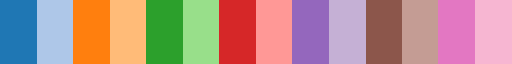

In [111]:
custom_cmap

Using tSNE


In [112]:
from sklearn.manifold import TSNE
X = data_corrected.values 
tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(X)
# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
x=tSNE_result[:,0]
y=tSNE_result[:,1]

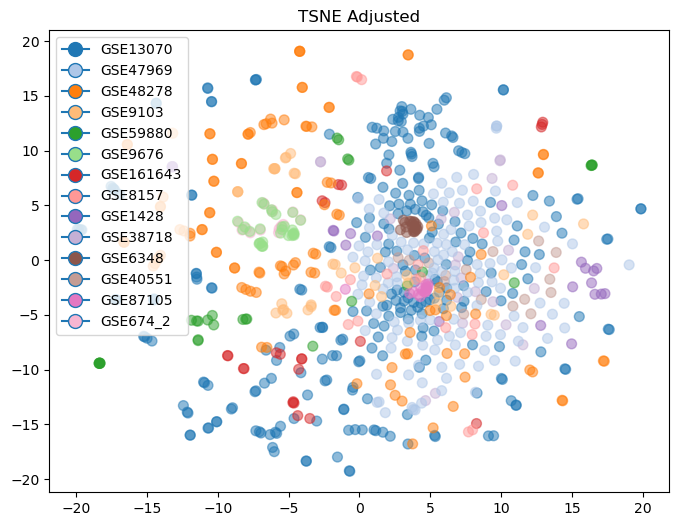

In [113]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Adjusted')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Combat_by_experiment.png"
plt.savefig(save)

Using PCA

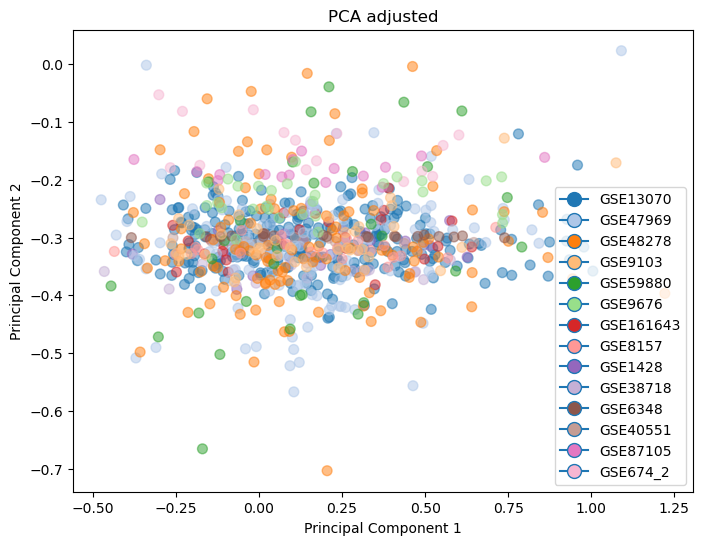

In [114]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA adjusted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Combat_by_experiment_double_nomr.png"
plt.savefig(save)

Lookign at the age

In [115]:



# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(age_order)}
category_map = {'Young': -1,  'MiddleAge': 0, 'Old': 1}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_age_order = [category_map[experiment] for experiment in age_order]
tab20_colors = plt.cm.tab10.colors
num_colors = len(np.unique(age_order))
colors = [tab20_colors[i] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)


In [116]:
pd.DataFrame(age_order).value_counts()

MiddleAge    571
Young        128
Old           78
Name: count, dtype: int64

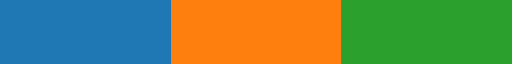

In [117]:
custom_cmap

tSNE

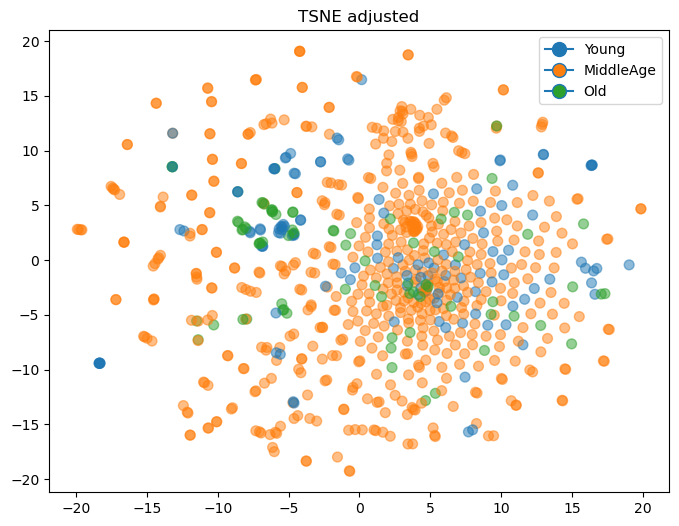

In [118]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE adjusted')

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Combat_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Age_reCombat.jpg")

PCA

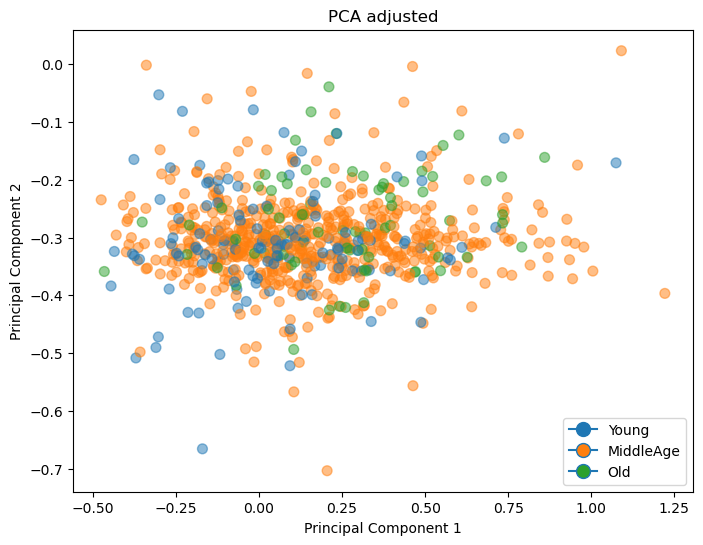

In [119]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA adjusted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Combat_by_age_double_norm.png"
plt.savefig(save)
# plt.savefig("PCA_Scatter_Plot_Age_reCombat.jpg")

Unadjusted

In [120]:
X = cts_processed.values 


tSNE by experiment

In [121]:

tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(X)
# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
x=tSNE_result[:,0]
y=tSNE_result[:,1]

In [122]:
# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(experiment_order)}
if technology =="RNAseq":
    category_map = {'GSE164471': -1, 'GSE152558': 0, 'GSE157585': 1, 'GSE167186':2, "GSE60590":3, "GSE129643":4}
elif technology == "microarray":
    category_map = {'GSE13070':-6, 'GSE47969':-5, 'GSE48278':-4, 'GSE9103':-3, 'GSE59880':-2, 'GSE9676':-1, 'GSE161643':0, 'GSE8157':1, 'GSE1428':2, 'GSE38718':3, 'GSE6348':4, 'GSE40551':5, 'GSE87105':6, 'GSE674_2':7}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_experiment_order = [category_map[experiment] for experiment in experiment_order]

from matplotlib.colors import ListedColormap
tab20_colors = plt.cm.tab20.colors
num_colors = len(np.unique(experiment_order))
colors = [tab20_colors[i ] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)

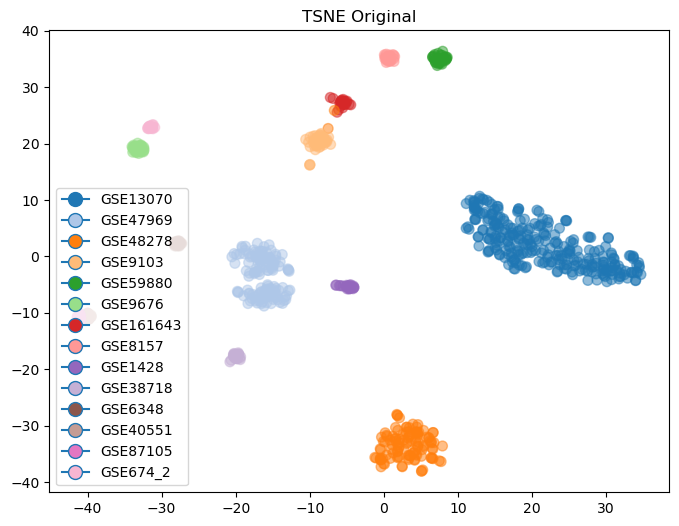

In [123]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Original')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Original_by_experiment_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Experiment_Original.jpg")

PCA by experiment original

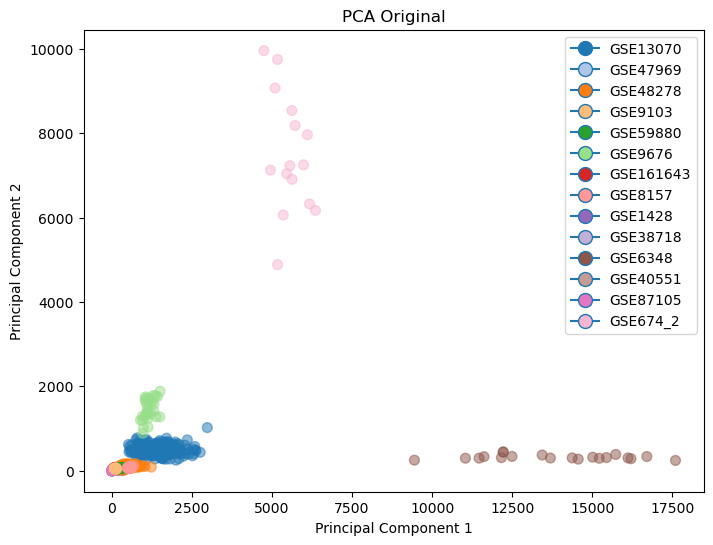

In [124]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA Original')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Original_by_experiment_double_norm.png"
plt.savefig(save)
#plt.savefig("PCA_Scatter_Plot_Experiment_Original.jpg")

By age

In [125]:

# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(age_order)}
category_map = {'Young': -1,  'MiddleAge': 0, 'Old': 1}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_age_order = [category_map[experiment] for experiment in age_order]
tab20_colors = plt.cm.tab10.colors
num_colors = len(np.unique(age_order))
colors = [tab20_colors[i % 20] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)

TSNE by age

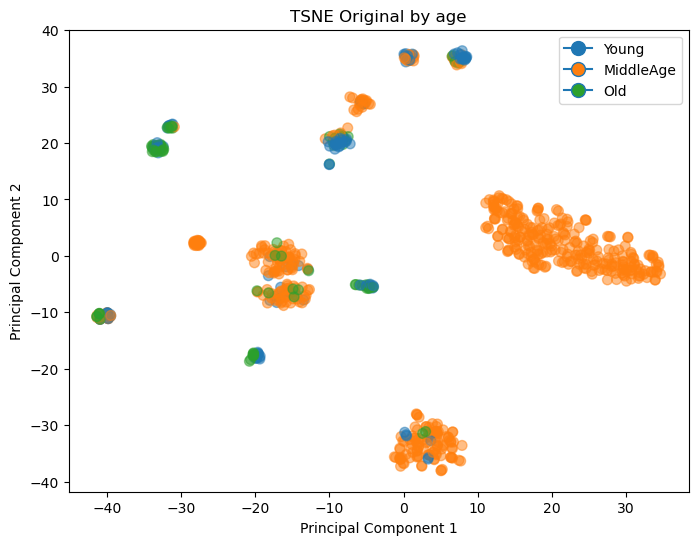

In [126]:


# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Original by age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Original_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Age_Original.jpg")

PCA by age original

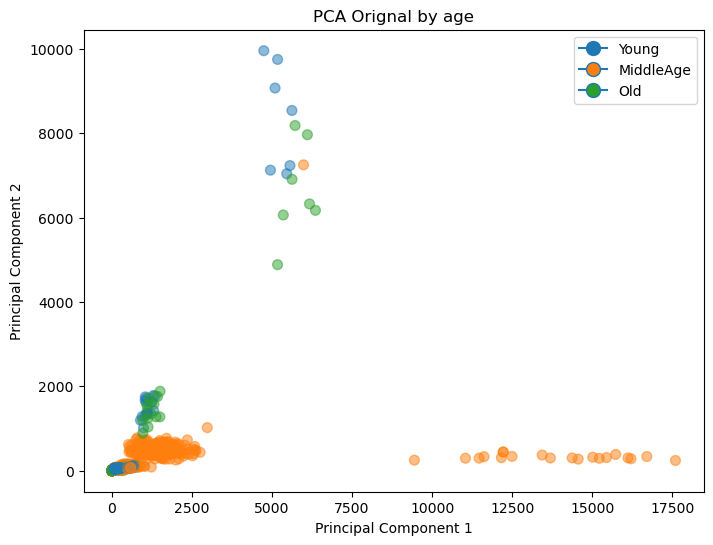

In [127]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA Orignal by age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Original_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("PCA_Scatter_Plot_Age_Original.jpg")

UMAP